___

# Quail segmentation and feature extraction exploration #

<!-- *12 January 2023* -->
<!-- *19 January 2023* -->
*18 January 2023*


## Previous analysis ##

Cropped node and non-node regions:

`Quail_01_Region_Crop.ipynb`

Scale and $\sigma$ influences on watershed segmentation

`Quail_02_Watershed.ipynb`

## Ideas ##

From Robert.

```
# annotation to cluster ID column => "good" vs "bad" segmentation
# look in feature plot ?  first try
# train APOC object selector or classification/classifier 
# segmentation post processing > Object classification # is it possible to only find 
# notbook loads segment / makes segment / loads measurements
# next time: try dimensionality reduction approaches

```

## Import tools ##

In [1]:
import napari
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.3
import napari_crop
import pyclesperanto_prototype as cle  # version 0.21.2
import pandas as pd

from napari_simpleitk_image_processing import label_statistics
from skimage.io import imread, imsave

import napari_skimage_regionprops as nsr

from sklearn.preprocessing import StandardScaler
import seaborn
import stackview

In [2]:
from apoc import ProbabilityMapper

## Set filenames ##

In [3]:
# source data
source_stack          = '/Volumes/Quail/Quail/220214_highresnode/220214_63x_node_scan_121t_11x11y_MERGED_rotated.tif'
datafolder            = 'data/'

# cropped regions
cropped_node_file     = f'{datafolder}220214_cropped_node.tif'
cropped_non_node_file = f'{datafolder}220214_cropped_non_node.tif'

# scaled files
cropped_node_scaled_file     = f'{datafolder}220214_cropped_node_scaled.tif'
cropped_non_node_scaled_file = f'{datafolder}220214_cropped_non_node_scaled.tif'

## Open viewer ##

In [4]:
viewer = napari.Viewer()

## Load node and non-node regions ##

One in Henson's node, the other in the periphery of the tissue

In [5]:
# viewer.open('/Volumes/Quail/Quail/220214_highresnode/220214_63x_node_scan_121t_11x11y_MERGED_rotated.tif')
cropped_node     = imread(cropped_node_file)
cropped_non_node = imread(cropped_non_node_file)

In [6]:
viewer.add_image(
    cropped_node,
    colormap='gray_r'
)

<Image layer 'cropped_node' at 0x1574d4b20>

In [7]:
viewer.add_image(
    cropped_non_node,
    colormap='gray_r'
)

<Image layer 'cropped_non_node' at 0x15bfa5c60>

## Scale 3D data ##

Allows exploration on local mac (M1 or Intel)

Also in `Quail_02_Watershed`.  Eventually remove redundant code blocks here.

In [8]:
voxel_size_xy = 1
voxel_size_z  = 5     # according to Adrian the pixels in this dataset are isotropic, but watershed works better with "deeper" cells
zoom          = 0.25 

cl.OCLArray([[[ 0.,  0.,  0., ...,  0.,  4., 16.],
        [ 0., 36., 26., ...,  0.,  0.,  5.],
        [ 0.,  0., 15., ...,  4., 14.,  0.],
        ...,
        [ 0.,  0., 11., ...,  6.,  6.,  0.],
        [ 0.,  1.,  0., ..., 23.,  0.,  4.],
        [ 0., 12., 18., ...,  0.,  8.,  0.]],

       [[ 0.,  6., 12., ...,  3.,  0., 10.],
        [31.,  0.,  0., ..., 13., 24., 10.],
        [13., 36.,  3., ...,  0.,  6., 12.],
        ...,
        [ 0.,  0., 13., ...,  7.,  2.,  0.],
        [ 0.,  7., 10., ...,  0., 10.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 7., 14., 17., ..., 15.,  0.,  4.],
        [ 0.,  0., 25., ...,  1.,  0.,  0.],
        [ 0.,  0.,  1., ..., 53.,  1.,  0.],
        ...,
        [13., 21.,  0., ...,  0.,  0.,  5.],
        [ 0.,  0.,  8., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  5.,  5.]],

       ...,

       [[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  3.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  5.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 12.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
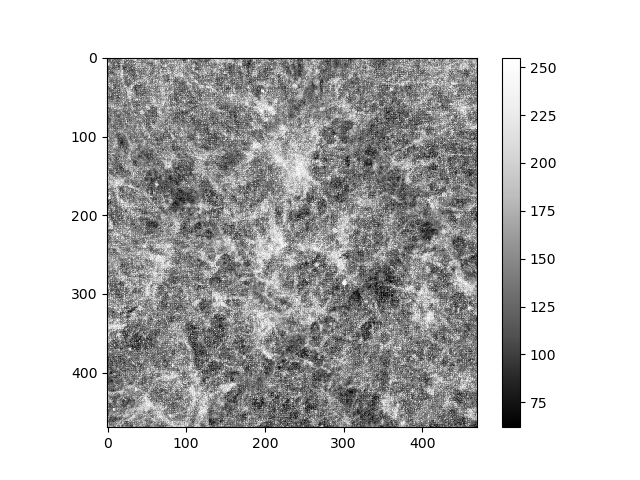
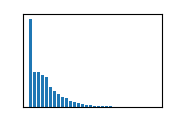

In [9]:
cropped_node_scaled = (
    cle.scale(
        cropped_node, 
        factor_x=voxel_size_xy*zoom, 
        factor_y=voxel_size_xy*zoom, 
        factor_z=voxel_size_z*zoom, 
        auto_size=True,
        linear_interpolation=True # linear interpolation not supported on intel cpu
    ) 
)
cropped_node_scaled

cl.OCLArray([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 3.,  0.,  0., ...,  0.,  0.,  5.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  3.,  0.,  0.]],

       [[ 5.,  0.,  5., ...,  0.,  0.,  5.],
        [ 0.,  0.,  0., ...,  0.,  0.,  7.],
        [ 0.,  0.,  8., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  7.],
        [ 1.,  0.,  7., ...,  2.,  0.,  2.],
        [ 3.,  0.,  0., ...,  5., 15.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 12., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  5.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 15., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 5.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0., 15.,  0.]],

       [[ 0.,  7.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 12., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  5.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
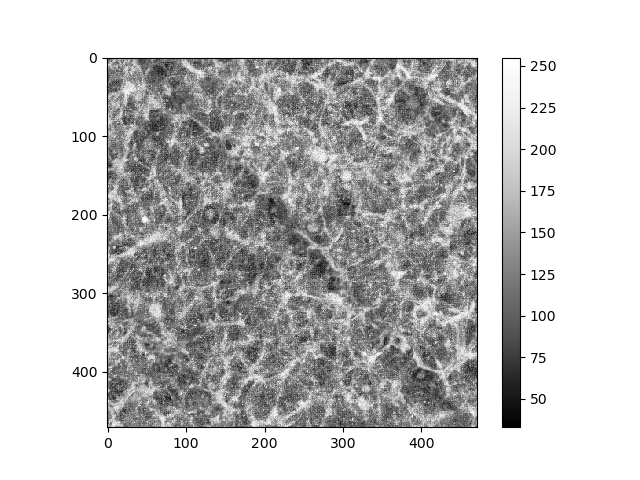
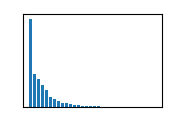

In [10]:
cropped_non_node_scaled = (
    cle.scale(
        cropped_non_node, 
        factor_x=voxel_size_xy*zoom, 
        factor_y=voxel_size_xy*zoom, 
        factor_z=voxel_size_z*zoom, 
        auto_size=True,
        # linear_interpolation=True # linear interpolation not supported on intel cpu
    ) 
)
cropped_non_node_scaled

## View scaled files ##

In [11]:
cropped_node_scaled_layer = (
    viewer.add_image(
        cropped_node_scaled, 
        colormap='gray_r',
        interpolation3d='bicubic',
        contrast_limits=[0,255],
    )
)

In [12]:
cropped_non_node_scaled_layer = (
    viewer.add_image(
        cropped_non_node_scaled, 
        colormap='gray_r',
        interpolation3d='bicubic',
        contrast_limits=[0,255],
    )
)

## Save scaled files ##

In [13]:
cropped_node_scaled_file, cropped_non_node_scaled_file

('data/220214_cropped_node_scaled.tif',
 'data/220214_cropped_non_node_scaled.tif')

In [14]:
imsave(cropped_node_scaled_file, cropped_node_scaled, plugin='tifffile')

In [15]:
imsave(cropped_non_node_scaled_file, cropped_non_node_scaled, plugin='tifffile')

## Close unneeded layers ##

Free up memory.

In [16]:
viewer.layers.remove('cropped_node')

In [17]:
viewer.layers.remove('cropped_non_node')

In [18]:
viewer.layers.remove('cropped_node_scaled')

In [19]:
viewer.layers.remove('cropped_non_node_scaled')

In [20]:
viewer.reset_view()

___

# *Start here* #

Import tools, set filenames and open viewer first.

## Load scaled node and non-node crops ##

One in Henson's node, the other in the periphery of the tissue; scaled here or in `Quail_02_Watershed.ipynb`

In [21]:
# viewer.open('/Volumes/Quail/Quail/220214_highresnode/220214_63x_node_scan_121t_11x11y_MERGED_rotated.tif')
cropped_node_scaled     = imread(cropped_node_scaled_file)
cropped_non_node_scaled = imread(cropped_non_node_scaled_file)

In [22]:
viewer.add_image(
    cropped_node_scaled,
    colormap='gray_r'
)

<Image layer 'cropped_node_scaled' at 0x152946860>

In [23]:
viewer.add_image(
    cropped_non_node_scaled,
    colormap='gray_r',
    visible=False,
)

<Image layer 'cropped_non_node_scaled' at 0x15ce15540>

In [24]:
viewer.reset_view()

## Gaussian blur ##

In [30]:
# gaussian blur
cropped_node_scaled_gaussian_blur = cle.gaussian_blur(cropped_node_scaled, None, 1.0, 1.0, 1.0)
viewer.add_image(
    cropped_node_scaled_gaussian_blur, 
    name='cropped_node_scaled_gaussian_blur',
    colormap='gray_r',
    visible=True,
    contrast_limits=[0,255]
)


<Image layer 'cropped_node_scaled_gaussian_blur [1]' at 0x178af6260>

In [26]:
# gaussian blur
cropped_non_node_scaled_gaussian_blur = cle.gaussian_blur(cropped_non_node_scaled, None, 1.0, 1.0, 1.0)
viewer.add_image(
    cropped_non_node_scaled_gaussian_blur, 
    name='cropped_non_node_scaled_gaussian_blur',
    colormap='gray_r',
    visible=False,
)


<Image layer 'cropped_non_node_scaled_gaussian_blur' at 0x15cf4bee0>

## Initial watershed segmentation ##

From `Quail_02_Watershed.ipynb`, use parameters of XYZ (1,1,5) and spot $\sigma$ of 30 and outline $\sigma$ of 7 for an intial segmentation.

In [34]:
# set above / earlier in this notebook
# voxel_size_xy = 1
# voxel_size_z  = 5     # according to Adrian the pixels in this dataset are isotropic
# zoom          = 0.25 

spot_sigma = 30
outline_sigma = 7

In [35]:
ss = spot_sigma
os = outline_sigma
label_title = f'spot{ss:02}_outline{os:02}'

lmsw_3d                 = nsbatwm.local_minima_seeded_watershed(cropped_node_scaled, ss*zoom, os*zoom)
exclude_labels_on_edges = cle.exclude_labels_on_edges(lmsw_3d)
exclude_small_labels    = cle.exclude_small_labels( exclude_labels_on_edges, None, 400*zoom)

viewer.add_labels(lmsw_3d,                 name=f'{label_title}',                          opacity=0.5)
viewer.add_labels(exclude_labels_on_edges, name=f'{label_title}_exclude_edges',            opacity=0.5)
viewer.add_labels(exclude_small_labels,    name=f'{label_title}_exclude_edges_and_small ', opacity=0.5)

<Labels layer 'spot30_outline07_exclude_edges_and_small ' at 0x15cb02e60>

## Watershed optimization: maintain edges ##

Excluding labels edges excludes the top layer of cells around the node. Explore classifying pixels to maintain top layer labels.

In XZ, slices 40, 70,  

File:

`data/Segmenter_keep_top_edges.cl`

## Probability mapper ##

In [1]:
# python code to apply this object segmenter
# read APOC documentation
# 


segmenter = ProbabilityMapper(opencl_filename='/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/GrillLab/Projects/quail/ProbabilityMapper.cl')

result = segmenter.predict(image=cropped_node_scaled)

NameError: name 'ProbabilityMapper' is not defined

In [ ]:
len(result)

In [ ]:
result[120]

In [ ]:
# Robert suggested 25 and 5 for the spot sigma and outline sigmas
# By my eye, 30 and 10 are a bit better
lmsw_3d = nsbatwm.local_minima_seeded_watershed(result, 30*zoom, 10.0*zoom)

In [ ]:
# viewer = napari.Viewer()
viewer.add_labels(lmsw_3d)

In [ ]:
# annotation to cluster ID column => "good" vs "bad" segmentation
# look in feature plot ?  first try
# train APOC object selector or classification/classifier 
# segmentation post processing > Object classification # is it possible to only find 
# notbook loads segment / makes segment / loads measurements
# next time: try dimensionality reduction approaches